In [3]:
import requests
import pandas as pd
import io
pd.set_option('display.max_columns', None)

c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Rainfall

In [50]:

def get_rain_data( time_min , time_max, station_code ):
    
    # Prapare parameters
    time_min = pd.to_datetime(time_min,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    time_max = pd.to_datetime(time_max,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    timerange = f"{time_min}/{time_max}"
    payload = "variables[]=tair@degC&variables[]=tslo@degC&variables[]=relh@percent&variables[]=precip:incremental@mm&variables[]=precip@mm&variables[]=precip_local@mm&variables[]=precip_total@mm&variables[]=precip_max_intensity@mm/min&variables[]=winds_sonic@m/s&variables[]=srad@W/m^2&variables[]=pres@millibars&variables[]=snow_depth@mm&variables[]=lat@degrees&variables[]=lon@degrees"

    # query and df
    url = f'https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/{timerange}?{payload}'
    response = requests.get(url)
    df = pd.read_csv(io.StringIO( response.content.decode('utf-8')))

    # filter to one station
    df = df[ df['station'] == station_code.upper() ]

    # convert to datetime and format
    df['time_NY'] = pd.to_datetime(df['datetime']).dt.tz_convert('America/New_York').dt.tz_localize(None)
    df = df[['datetime', 'station','time_NY','precip_max_intensity [mm/min]']]
    df.columns = df.columns.str.replace(' [mm/min]','_mmmin')

    # convert mm/min to in/min
    df['precip_max_intensity_inmin'] = df['precip_max_intensity_mmmin'] * 0.0393701

    return df

# 2021-09-02 01:27:30+00:00	2021-09-02 03:11:30+00:00
time_min = "2021-09-02 01:27:30+00:00"
time_max = "2021-09-02 03:11:30+00:00"

station_code = 'bknyrd'
data = get_rain_data( time_min , time_max , station_code )

print( data.shape[0] )
data.head()

21


,datetime,station,time_NY,precip_max_intensity_mmmin,precip_max_intensity_inmin
2,2021-09-02 01:30 UTC,BKNYRD,2021-09-01 21:30:00,3.28,0.129134
19,2021-09-02 01:35 UTC,BKNYRD,2021-09-01 21:35:00,2.21,0.087008
36,2021-09-02 01:40 UTC,BKNYRD,2021-09-01 21:40:00,3.02,0.118898
53,2021-09-02 01:45 UTC,BKNYRD,2021-09-01 21:45:00,2.95,0.116142
70,2021-09-02 01:50 UTC,BKNYRD,2021-09-01 21:50:00,1.13,0.044488


<AxesSubplot:xlabel='time_NY'>

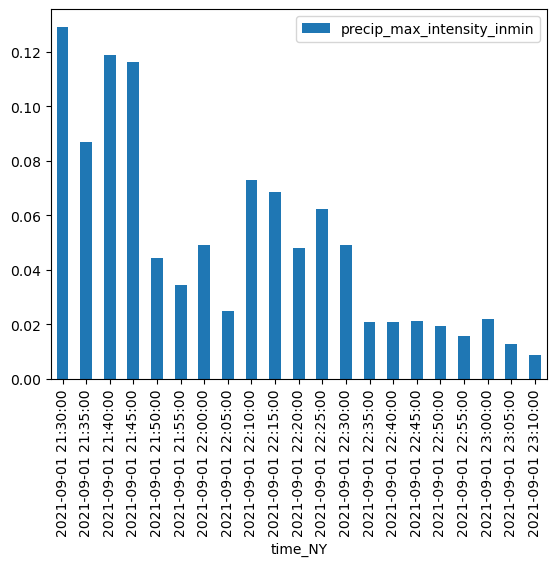

In [52]:
data.plot( x='time_NY', y='precip_max_intensity_inmin' , kind='bar')

### USGS Tidal

In [39]:

station = 'usgs-tidal-01311850'
time_min = "2022-09-07 04:37:00+00:00"
time_max = "2022-09-12 21:03:00+00:00"

def get_usgs_tidal_info( station , time_min , time_max ):
    
    time_min = pd.to_datetime(time_min,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    time_max = pd.to_datetime(time_max,utc=True).strftime('%Y-%m-%dT%H:%M:%S.%fZ')

    url = f'https://waterservices.usgs.gov/nwis/iv/?format=json&sites={station.split("-")[-1]}&parameterCd=62620&siteStatus=all&startDT={time_min}&endDT={time_max}'

    df = requests.get(url).json()
    tidal = pd.DataFrame( df['value']['timeSeries'][0]['values'][0]['value'] )
    tidal['dateTime'] = pd.to_datetime( tidal['dateTime'] )
    tidal['time_NY'] = tidal['dateTime'].dt.tz_localize(None)
    tidal['value'] = pd.to_numeric( tidal['value'] )
    tidal = tidal[['time_NY', 'dateTime' ,'value']]

    # !!! Add NAV88 to offset !!!
    
    # Not sure if this is necessary
    tidal = tidal[ 
        (tidal['time_NY'] > pd.to_datetime(time_min,utc=True).tz_convert('America/New_York').tz_localize(None)) & 
        (tidal['time_NY'] < pd.to_datetime(time_max,utc=True).tz_convert('America/New_York').tz_localize(None))]

    return tidal

tidal = get_usgs_tidal_info( station , time_min , time_max )
tidal.head()

,time_NY,dateTime,value
10,2022-09-07 00:42:00,2022-09-07 00:42:00-05:00,-1.16
11,2022-09-07 00:48:00,2022-09-07 00:48:00-05:00,-1.03
12,2022-09-07 00:54:00,2022-09-07 00:54:00-05:00,-0.87
13,2022-09-07 01:00:00,2022-09-07 01:00:00-05:00,-0.71
14,2022-09-07 01:06:00,2022-09-07 01:06:00-05:00,-0.55


<AxesSubplot:xlabel='time_NY'>

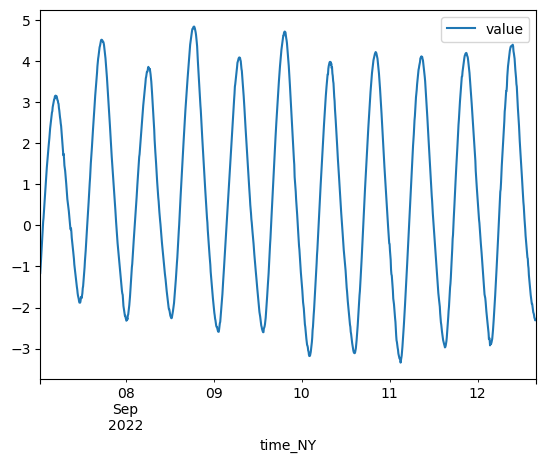

In [41]:
tidal.plot( x='time_NY', y='value' )

### NOAA Tidal

In [66]:

station = 'noaa-tidal-8518750'
time_min = "2021-09-02 01:27:30+00:00"
time_max = "2021-09-03 09:11:30+00:00"

def get_noaa_tidal_info( station , time_min , time_max ):
    
    # event_startdate.strftime("%Y%m%d")
    time_min = pd.to_datetime(time_min,utc=True).tz_convert("America/New_York").strftime('%Y%m%d %H:%M')
    time_max = pd.to_datetime(time_max,utc=True).tz_convert("America/New_York").strftime('%Y%m%d %H:%M')

    url = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={ time_min }&end_date={ time_max }&station={station.split("-")[-1]}&product=water_level&datum=NAVD&time_zone=gmt&units=english&application=DataAPI_Sample&format=json'
    r = requests.get(url)

    data = r.json()['data']
    df = pd.DataFrame( data )
    df['time_NY'] = pd.to_datetime(df['t'], utc=True ).dt.tz_convert('US/Eastern').dt.tz_localize(None)
    df = df.drop(['q','f'],axis=1)
    df['v'] = pd.to_numeric( df['v'] )
    return df

tidal = get_noaa_tidal_info( station , time_min , time_max )
tidal


,t,v,s,time_NY
0,2021-09-01 21:30,2.740,0.285,2021-09-01 17:30:00
1,2021-09-01 21:36,2.730,0.161,2021-09-01 17:36:00
2,2021-09-01 21:42,2.717,0.305,2021-09-01 17:42:00
3,2021-09-01 21:48,2.680,0.148,2021-09-01 17:48:00
4,2021-09-01 21:54,2.621,0.184,2021-09-01 17:54:00
...,...,...,...,...
312,2021-09-03 04:42,-1.539,0.030,2021-09-03 00:42:00
313,2021-09-03 04:48,-1.483,0.030,2021-09-03 00:48:00
314,2021-09-03 04:54,-1.430,0.023,2021-09-03 00:54:00
315,2021-09-03 05:00,-1.385,0.016,2021-09-03 01:00:00


<AxesSubplot:xlabel='time_NY'>

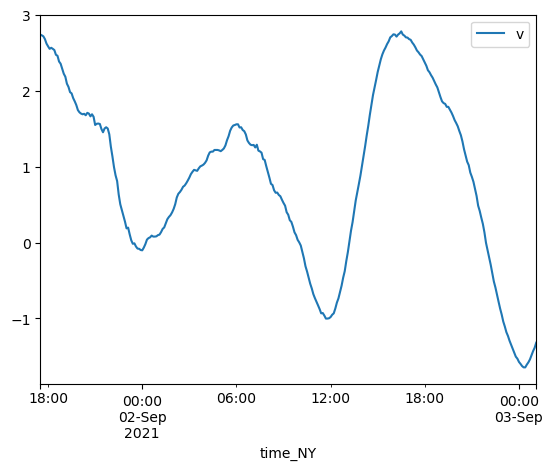

In [67]:
tidal.plot( x='time_NY', y='v' )